In [2]:
# Libraries, parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.stats import poisson
import math

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Importing hypotheses and bin edges
hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

# concatenating
frames = [bin_edges, hypotheses]
ngc_chart = pd.concat(frames, axis=1)

# Importing effective area data:
eff_a = np.loadtxt('effA_-5to30.dat')

# Limits of energy bins in the effective area data:
e_min = 1e-1
e_max = 7.94328e5

# More parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 over 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # In log10 scale, for track-like events

# del_m2
del_m2 = 10**(-17.8)

base = 10

In [59]:
# Some unit conversions

del_m2 = 10**(-14)
TeV = 2

eV_1 = (4*np.pi*TeV*10**(12))/del_m2
conv = 5.06773093741 * 1e6 * 3.086e+16 # 1/eV to parsecs

print(eV_1/conv)



16070.537008442834


In [3]:
# Define the integrands

def F(log_e_reco):

    exp_e_reco = 10**(log_e_reco)

    flux = 3*phi0*(exp_e_reco/e0)**(-index)

    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_reco)

    osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    fx = flux*effa*prob_mu

    return fx


def G(log_e_reco):
    return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

In [20]:
# Letting del_m2 values differ
def Fdiffdel(log_e_reco, dm2_1, dm2_2, dm2_3):

    exp_e_reco = 10**(log_e_reco)

    flux = 3*phi0*(exp_e_reco/e0)**(-index)

    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_reco)

    osc1 = (np.cos((dm2_1 * l_eff)/(4*exp_e_reco*1e12)))**2
    osc2 = (np.cos((dm2_2 * l_eff)/(4*exp_e_reco*1e12)))**2
    osc3 = (np.cos((dm2_3 * l_eff)/(4*exp_e_reco*1e12)))**2
    prob_surv = osc1*((u_m[1]*u_m[1]) + osc2*(u_m[2]*u_m[2]) + osc3*(u_m[3]*u_m[3]))
    prob_emu = osc1*((u_e[1]*u_m[1]) + osc2*(u_e[2]*u_m[2]) + osc3*(u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    fx = flux*effa*prob_mu

    return fx

In [4]:
# Define the bins

num_bins = 10000
a = np.linspace(-1, 3, num_bins)

In [5]:
# Discretize F and G

F_sample = []
for i in range(num_bins):
    F_sample.append(F(a[i]))

G_sample = []
for i in range(num_bins):
    G_sample.append(G(a[i]))

# Translation factor to make this fit with the expected results
H = []
for i in range(int(num_bins/2)):
    H.append(0)
G_sample = H+G_sample

In [6]:
# Convolve

convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])

b = np.linspace(-1, 3, len(convolution))

FG = interp1d(b, convolution)

In [7]:
# Taking the outside integrand (FFTconv alg)

def NewIntegrand(log_e_reco):
    return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

def FFTIntegral(log_e_start, log_e_end):
    return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

In [25]:
# Big Boy Integral Function: outputs entire event distribution for some PD hypothesis

def BigIntegral(del_m2):

    # Define the integrand functions
    def F(log_e_reco, del_m2):

        exp_e_reco = 10**(log_e_reco)

        flux = 3*phi0*(exp_e_reco/e0)**(-index)

        x = eff_a[:,0]
        y = eff_a[:,4]
        f = interp1d(x, y)
        effa = 10000*f(exp_e_reco)

        osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
        prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
        prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
        prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

        fx = flux*effa*prob_mu

        return fx

    def G(log_e_reco):
        return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

    # Define the bins
    num_bins = 10000
    a = np.linspace(-1, 3, num_bins)

    # Discretize F and G
    F_sample = []
    G_sample = []
    for i in range(num_bins):
        F_sample.append(F(a[i], del_m2))
        G_sample.append(G(a[i]))
  
    # Translation factor to make this fit with the expected results
    H = []
    for i in range(int(num_bins/2)):
        H.append(0)
    G_sample = H+G_sample

    # Convolve
    convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])
    b = np.linspace(-1, 3, len(convolution))
    FG = interp1d(b, convolution)

    # Take outside integral, first changing to log energy scale
    def NewIntegrand(log_e_reco):
        return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

    def FFTIntegral(log_e_start, log_e_end):
        return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

    # record data
    int_FFT = []
    for i in range(len(ngc_chart['energy'])-1):
        e_t = np.log10(ngc_chart['energy'][i])
        e_t_next = np.log10(ngc_chart['energy'][i+1])
        int_FFT.append(FFTIntegral(e_t, e_t_next))
    int_FFT.append(0)

    return int_FFT

In [60]:
# Big Boy Integral, letting del_m2 values differ:

def BIdiffdel(dm2_1, dm2_2, dm2_3):

    def Fdiffdel(log_e_reco, dm2_1, dm2_2, dm2_3):

        exp_e_reco = 10**(log_e_reco)

        flux = 3*phi0*(exp_e_reco/e0)**(-index)

        x = eff_a[:,0]
        y = eff_a[:,4]
        f = interp1d(x, y)
        effa = 10000*f(exp_e_reco)

        osc1 = (np.cos((dm2_1 * l_eff)/(4*exp_e_reco*1e12)))**2
        osc2 = (np.cos((dm2_2 * l_eff)/(4*exp_e_reco*1e12)))**2
        osc3 = (np.cos((dm2_3 * l_eff)/(4*exp_e_reco*1e12)))**2
        prob_surv = osc1*(u_m[1]*u_m[1]) + osc2*(u_m[2]*u_m[2]) + osc3*(u_m[3]*u_m[3])
        prob_emu = osc1*(u_e[1]*u_m[1]) + osc2*(u_e[2]*u_m[2]) + osc3*(u_e[3]*u_m[3])
        prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

        fx = flux*effa*prob_mu

        return fx

    def G(log_e_reco):
        return (1/(width*np.sqrt(2*np.pi)))*np.exp(-0.5*((log_e_reco)/width)**2)

    # Define the bins
    num_bins = 10000
    a = np.linspace(-1, 3, num_bins)

    # Discretize F and G
    F_sample = []
    G_sample = []
    for i in range(num_bins):
        F_sample.append(Fdiffdel(a[i], dm2_1, dm2_2, dm2_3))
        G_sample.append(G(a[i]))
  
    # Translation factor to make this fit with the expected results
    H = []
    for i in range(int(num_bins/2)):
        H.append(0)
    G_sample = H+G_sample

    # Convolve
    convolution = fftconvolve(F_sample, G_sample, mode='same')*(a[1]-a[0])
    b = np.linspace(-1, 3, len(convolution))
    FG = interp1d(b, convolution)

    # Take outside integral, first changing to log energy scale
    def NewIntegrand(log_e_reco):
        return np.log(10)*np.power(10, log_e_reco)*FG(log_e_reco)

    def FFTIntegral(log_e_start, log_e_end):
        return quad(NewIntegrand, log_e_start, log_e_end, limit=50, epsabs=0.5)[0]

    # record data
    int_FFT = []
    for i in range(len(ngc_chart['energy'])-1):
        e_t = np.log10(ngc_chart['energy'][i])
        e_t_next = np.log10(ngc_chart['energy'][i+1])
        int_FFT.append(FFTIntegral(e_t, e_t_next))
    int_FFT.append(0)

    return int_FFT


Text(0.5, 1.0, '$\\sigma_{logE} = 0.1$')

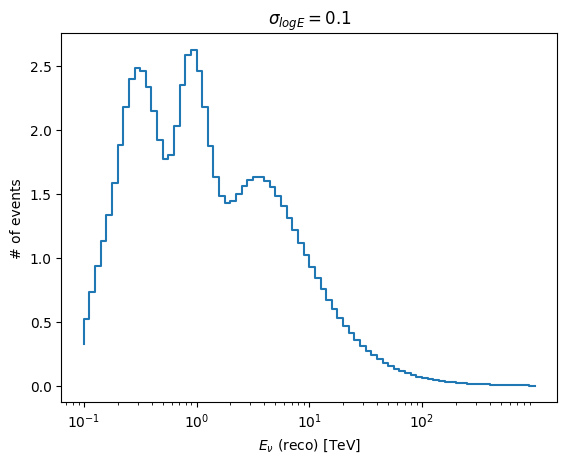

In [58]:
# Plotting nonequal del_m2 values

fig, ax = plt.subplots()
intFFT_null, = ax.step(ngc_chart['energy'], BIdiffdel(0, 10**(-17.8), 10**(-17.3)))
# intFFT_178, = ax.step(ngc_chart['energy'], BigIntegral(10**(-17.8)))
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\sigma_{logE} = 0.1$")

In [9]:
# Record data

int_FFT = []
for i in range(len(ngc_chart['energy'])-1):
    e_t = np.log10(ngc_chart['energy'][i])
    e_t_next = np.log10(ngc_chart['energy'][i+1])
    int_FFT.append(FFTIntegral(e_t, e_t_next))
int_FFT.append(0)

In [10]:
# An array?

int_log = [0.6757058017786692, 0.8573182535684952, 1.0679660024453075, 1.3070387454756738, 1.572591367662683, 1.8614009607327557, 2.1690184103021504, 2.4899496180235507, 2.8179863984517928, 3.146464684352356, 3.4686653780320924, 3.7776432716376793, 4.067823010363738, 4.333483566958605, 4.570020528436862, 4.774392371372071, 4.9438202672936775, 5.076922571433013, 5.173232182975918, 5.233048973381582, 5.2575646751258, 5.24841631699087, 5.20810824069066, 5.137950505586633, 5.041717558639807, 4.9218327721705455, 4.782212837736808, 4.624659988924319, 4.4524696935415164, 4.268655748199039, 4.075022739156777, 3.8748157180143306, 3.6703282087173723, 3.4633758390120724, 3.2560476634800253, 3.0500154167825593, 2.8468257442433966, 2.6478728116513226, 2.45432970156842, 2.2671797088593193, 2.087303679823762, 1.915340376090762, 1.7518296224281449, 1.5970721884158479, 1.451377311372507, 1.3148586446379156, 1.1874403283918262, 1.068970724356898, 0.9592745082991013, 0.8588232468858853, 0.7663180464343213, 0.6817900635193611, 0.6048464815515292, 0.5350795595886924, 0.47204946206870835, 0.4153105186390735, 0.364420449285836, 0.3189284722413102, 0.27839688662422263, 0.2423943684318369, 0.21054987709054798, 0.1824293070169234, 0.15774953240295297, 0.13600702414347132, 0.11703503841436994, 0.10047731277759772, 0.0860821706003086, 0.073581577574633, 0.0627862833337464, 0.053435258790604366, 0.045411186163466344, 0.038506712403933996, 0.03258507032366423, 0.027523439412415935, 0.023197293983073314, 0.019521165756936604, 0.016396328517904183, 0.013746684364611116, 0.011504386390451076, 0.009610117199540887]

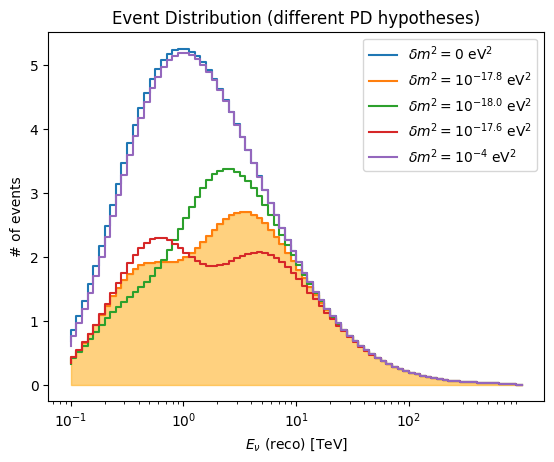

In [62]:
# Plot Event Distributions for different PD hyps (not free systematics)

fig, ax = plt.subplots()
intFFT_null, = ax.step(ngc_chart['energy'], BigIntegral(0))
intFFT_178, = ax.step(ngc_chart['energy'], BigIntegral(10**(-17.8)))
intFFT_180, = ax.step(ngc_chart['energy'], BigIntegral(10**(-18.0)))
intFFT_176, = ax.step(ngc_chart['energy'], BigIntegral(10**(-17.6)))
intFFT_4, = ax.step(ngc_chart['energy'], BigIntegral(10**(-19)))
# intFFT_20, = ax.step(ngc_chart['energy'], BigIntegral(10**(-20)))
# ax.fill_between(ngc_chart['energy'], BigIntegral(0), 0, color='blue', alpha=.1, step='pre')
ax.fill_between(ngc_chart['energy'], BigIntegral(10**(-17.8)), 0, color='orange', alpha=.5, step='pre')
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
# ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution (different PD hypotheses)", loc="center")
ax.legend([intFFT_null, intFFT_178, intFFT_180, intFFT_176, intFFT_4], [r"$\delta m^2 = 0$ eV$^2$", r"$\delta m^2 = 10^{-17.8}$ eV$^2$", r"$\delta m^2 = 10^{-18.0}$ eV$^2$", r"$\delta m^2 = 10^{-17.6}$ eV$^2$", r"$\delta m^2 = 10^{-4}$ eV$^2$"])

In [63]:
# Def F integrand (no Gauss)

def F(log_e_reco):

    exp_e_reco = 10**(log_e_reco)

    flux = 3*phi0*(exp_e_reco/e0)**(-index)

    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(exp_e_reco)

    osc = (np.cos((del_m2 * l_eff)/(4*exp_e_reco*1e12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    fx = flux*effa*prob_mu

    return fx

In [64]:
# Frequency calculations

e_reco = 1
del_m2 = 10**(-17.8)
norm = 3.086e22*5.06773093741*1e6
# key points:
x = 2*(del_m2*norm)/(4*e_reco*10**12)
print(x)


0.12393086323237315


In [65]:
# F integrand in length space

def Integrand(l_eff):

    l_eff = l_eff*3.086e22*5.06773093741*1e6

    flux = 3*phi0*(e_reco/e0)**(-index)

    x = eff_a[:,0]
    y = eff_a[:,4]
    f = interp1d(x, y)
    effa = 10000*f(e_reco)

    osc = (np.cos((del_m2 * l_eff)/(4*e_reco*10**12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu

    return flux*effa*prob_mu

In [66]:
# Osc probs in length space

def Osc(l_eff):

    l_eff = l_eff*3.086e22*5.06773093741*1e6

    osc = (np.cos((del_m2 * l_eff)/(4*e_reco*10**12)))**2
    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu 

    return prob_mu


In [67]:
# Record oscs over length

dist = np.arange(1, 3*14.4, 0.1)
Osc_sample = np.zeros((dist.size))
for i in range(dist.size):
    Osc_sample[i] = Osc(dist[i])

Text(0.5, 1.0, '$\\delta m^2 = 10^{-17.8}$ eV$^2$, $E_{\\nu} = 0.5$ TeV')

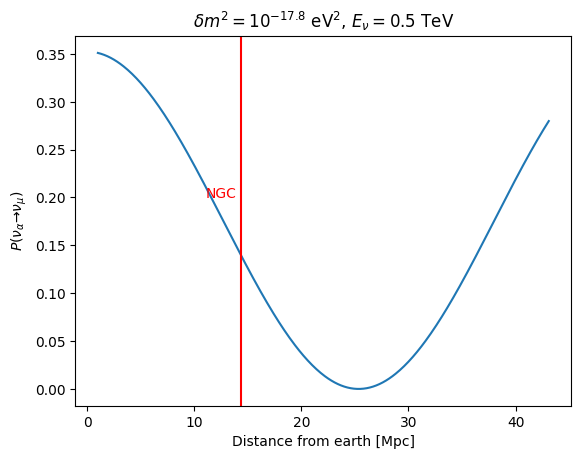

In [17]:
# Plot oscs over length

fig, ax = plt.subplots()
test = ax.plot(dist, Osc_sample)
ax.set_xlabel("Distance from earth [Mpc]")
ax.set_ylabel(r"$P(\nu_{\alpha} \to \nu_{\mu})$")
ax.axvline(x=14.4, color='red')
ax.text(11.1, 0.20, r"NGC", color='red')
ax.set_title(r"$\delta m^2 = 10^{-17.8}$ eV$^2$, $E_{\nu} = 0.5$ TeV")

In [18]:
# Fourier Transform the Function (in log E):

#Discretize the log energy
e0= -4
de=0.00001
e=np.arange(e0,3,de)
#Define function
F_dist = np.zeros((e.size))
for i in range(e.size):
    F_dist[i] = (Osc(e[i]))

#Compute Fourier transform by numpy's FFT function
g=np.fft.fft(F_dist)
#frequency normalization factor is 2*np.pi/dt
w = np.fft.fftfreq(F_dist.size)*2*np.pi/de

#In order to get a discretisation of the continuous Fourier transform
#we need to multiply g by a phase factor
g *= de*np.exp(-complex(0,1)*w*e0)/(np.sqrt(2*np.pi))

F = interp1d(w, g)

In [19]:
# Fourier Transform the Function (in distance): 

#Discretize the distance
l0=0.0001
dl=0.1
l=np.arange(l0,100*14.4,dl)
#Define function
F_dist = np.zeros((l.size))
for i in range(l.size):
    F_dist[i] = (Integrand(l[i]))

#Compute Fourier transform by numpy's FFT function
g=np.fft.fft(F_dist)
#frequency normalization factor is 2*np.pi/dl
w = np.fft.fftfreq(F_dist.size)*2*np.pi/dl

#In order to get a discretization of the continuous Fourier transform
#we need to multiply g by a phase factor
g *= dl*np.exp(-complex(0,1)*w*l0)/(np.sqrt(2*np.pi))



TypeError: float() argument must be a string or a real number, not 'complex'

In [ ]:
# Set frequency window sampling

freq_sample = np.arange(-1, 1, 0.01)
F_sample = []
for i in range(len(freq_sample)):
    F_sample.append(F(freq_sample[i]))

Text(0.5, 0, 'Frequency ($\\omega$) [s$^{-1}$]')

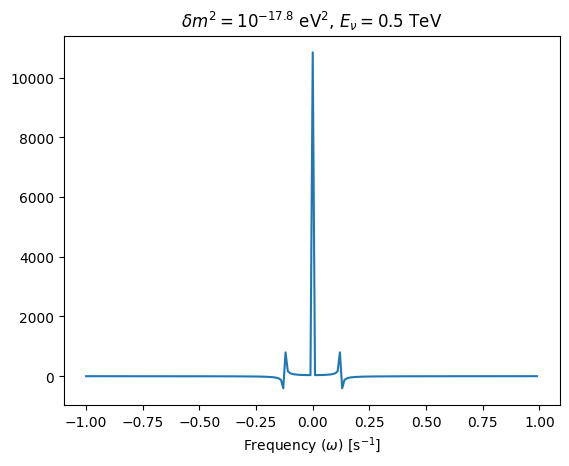

In [ ]:
# Plot FT (set freq sample)

fig, ax = plt.subplots()
ax.plot(freq_sample, F_sample)
ax.set_title(r"$\delta m^2 = 10^{-17.8}$ eV$^2$, $E_{\nu} = 0.5$ TeV")
ax.set_xlabel(r"Frequency ($\omega$) [s$^{-1}$]")